# Build an *ARMA* Predictive Time Series Model for Larcenies (WIP)
 _ this is a work in progress and needs further elaboration to be solid _

import python modules

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as datetime
import statsmodels.api as sm
from math import sqrt
import seaborn as sns

In [27]:
%matplotlib inline

set figure size

In [28]:
plt.rcParams['figure.figsize'] = (20.0, 8.0)

set seaborn style

In [83]:
sns.set_style("whitegrid")

# Load the data

In [30]:
# s is our raw series of observations
s = pd.read_pickle('lar_series.pkl')

In [31]:
X = s.resample('M').count()

In [32]:
X.describe()

count    161.000000
mean     171.782609
std       41.954394
min       26.000000
25%      149.000000
50%      166.000000
75%      198.000000
max      286.000000
Name: offense_short_description, dtype: float64

In [33]:
X.head()

incident_dt
2005-01-31    173
2005-02-28    157
2005-03-31    157
2005-04-30    182
2005-05-31    189
Freq: M, Name: offense_short_description, dtype: int64

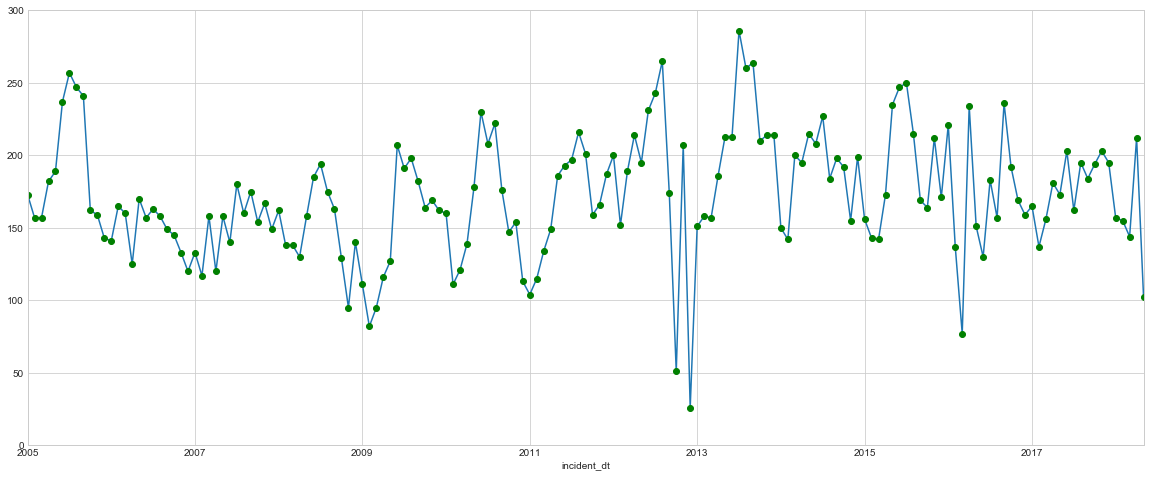

In [84]:
plt.ylim(0, 300)
X.plot()
X.plot(style='go', grid=True)

# Modeling the data with a time series analysis

lets build an ARMA model

http://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html

lets look at the ACF and PACF for signs of seasonality

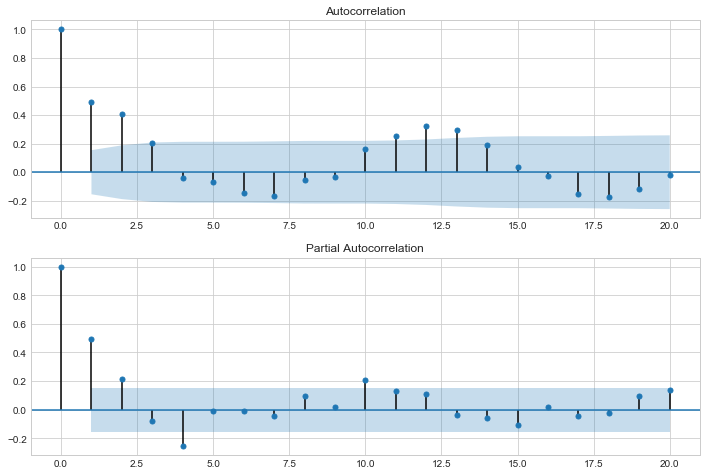

In [88]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X, lags=20, ax=ax2)

*Looks like a seasonal effect right around 12 months*

http://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html

statsmodels documentation suggests fitting an AR model to find the right lag 

In [89]:
model = sm.tsa.AR(X)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
# print('Coefficients: %s' % model_fit.params)

Lag: 14


In [91]:
# see this dicussion 
# https://github.com/statsmodels/statsmodels/issues/3247
X1 = X.astype(float)

A lag of 14 months is our "magic" number. But 12 months makes more sense based on the domain

In [92]:
# arma_mod1 = sm.tsa.ARMA(X, (14,1)).fit(disp=False)
arma_mod120 = sm.tsa.ARMA(X1, (12, 0)).fit(disp=False)

In [93]:
print(arma_mod120.aic, arma_mod120.bic, arma_mod120.hqic)

(1607.530633225816, 1650.6702943355986, 1625.0470880750038)


In [94]:
predicted = arma_mod2.predict(150, 160, dynamic=True)
actual = X[150:160]
compare = pd.DataFrame(actual)
compare.columns = ['actual']
compare['predicted'] = predicted
compare['difference'] = compare['actual'] - compare['predicted']
compare['percent error'] = (compare['difference']/compare['actual']) * 100.
print(compare)

             actual   predicted  difference  percent error
incident_dt                                               
2017-07-31      162  192.883076  -30.883076     -19.063627
2017-08-31      195  192.065227    2.934773       1.505012
2017-09-30      184  198.495318  -14.495318      -7.877890
2017-10-31      194  181.962580   12.037420       6.204856
2017-11-30      203  179.962229   23.037771      11.348656
2017-12-31      195  170.786276   24.213724      12.417295
2018-01-31      157  160.070919   -3.070919      -1.955999
2018-02-28      155  162.436151   -7.436151      -4.797516
2018-03-31      144  159.966755  -15.966755     -11.088025
2018-04-30      212  167.720820   44.279180      20.886406


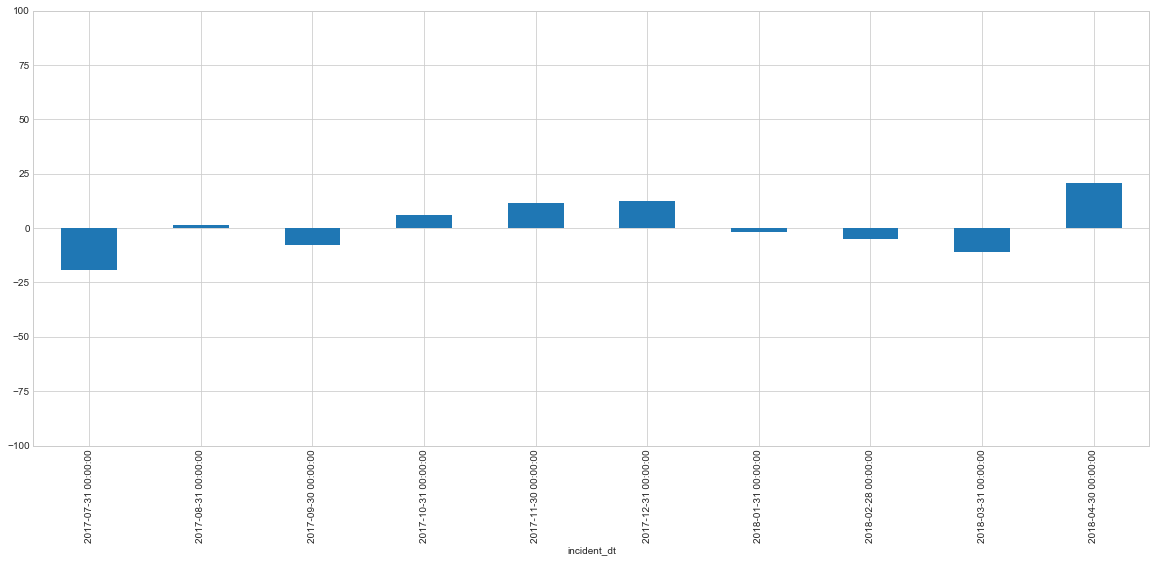

In [95]:
plt.ylim(-100,100)
compare['percent error'].plot(kind='bar')

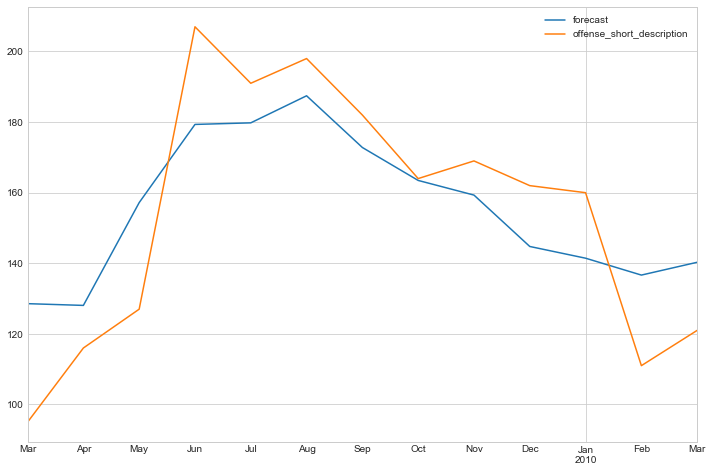

In [96]:
fig, ax = plt.subplots(figsize=(12, 8))
# ax = X[150:].plot(ax=ax)
fig = arma_mod2.plot_predict(50, 62, dynamic=True, ax=ax)

Lets do a thought experiment where we train the model on some number of months TM and use it to predict forward for some number of months PM

In [97]:
print("length of time series {}".format(len(X)))

length of time series 161


In [98]:
TM = 12*5 #train months
PM = 12 #predict months

In [99]:
train_size = TM
predict_size = PM
train, test = X[0:train_size], X[train_size:train_size + predict_size]
# using the 12 month model
predicted = arma_mod2.predict(train_size, train_size + predict_size, dynamic=True)

In [100]:
compare = pd.DataFrame(test)
compare.columns = ['actual']
compare['predicted'] = predicted
compare['difference'] = compare['actual'] - compare['predicted']
compare['percent error'] = (compare['difference']/compare['actual']) * 100.
print(compare)

             actual   predicted  difference  percent error
incident_dt                                               
2010-01-31      160  141.712169   18.287831      11.429894
2010-02-28      111  140.939732  -29.939732     -26.972731
2010-03-31      121  128.001578   -7.001578      -5.786428
2010-04-30      139  141.705508   -2.705508      -1.946409
2010-05-31      178  153.700347   24.299653      13.651490
2010-06-30      230  169.866195   60.133805      26.145133
2010-07-31      208  180.584645   27.415355      13.180459
2010-08-31      222  183.384667   38.615333      17.394294
2010-09-30      176  182.507700   -6.507700      -3.697557
2010-10-31      147  181.279024  -34.279024     -23.319064
2010-11-30      154  174.783008  -20.783008     -13.495460
2010-12-31      113  170.489112  -57.489112     -50.875320


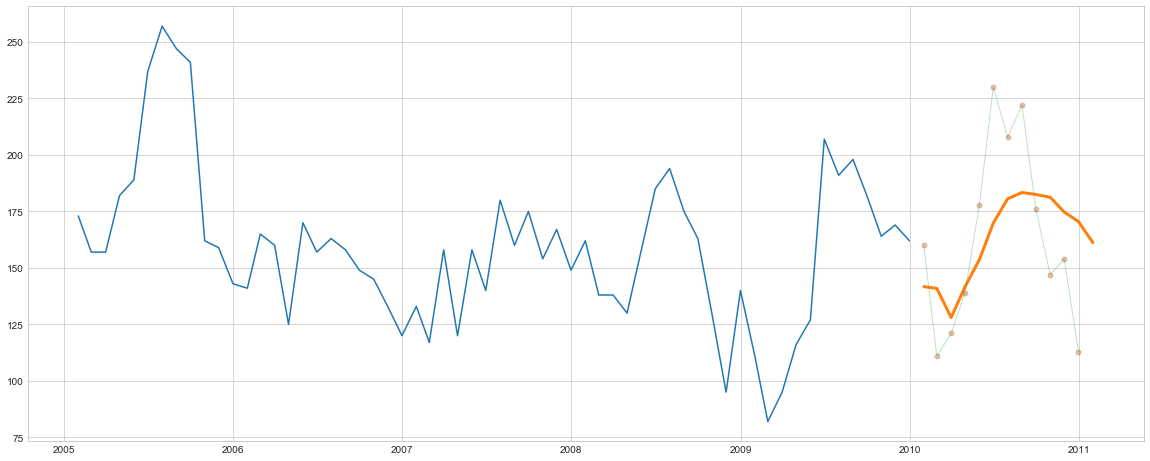

In [101]:
plt.plot(train)
plt.plot(predicted, lw=3.0)
plt.plot(test, '-o', ms=5, lw=1, alpha=0.3, mfc='red')

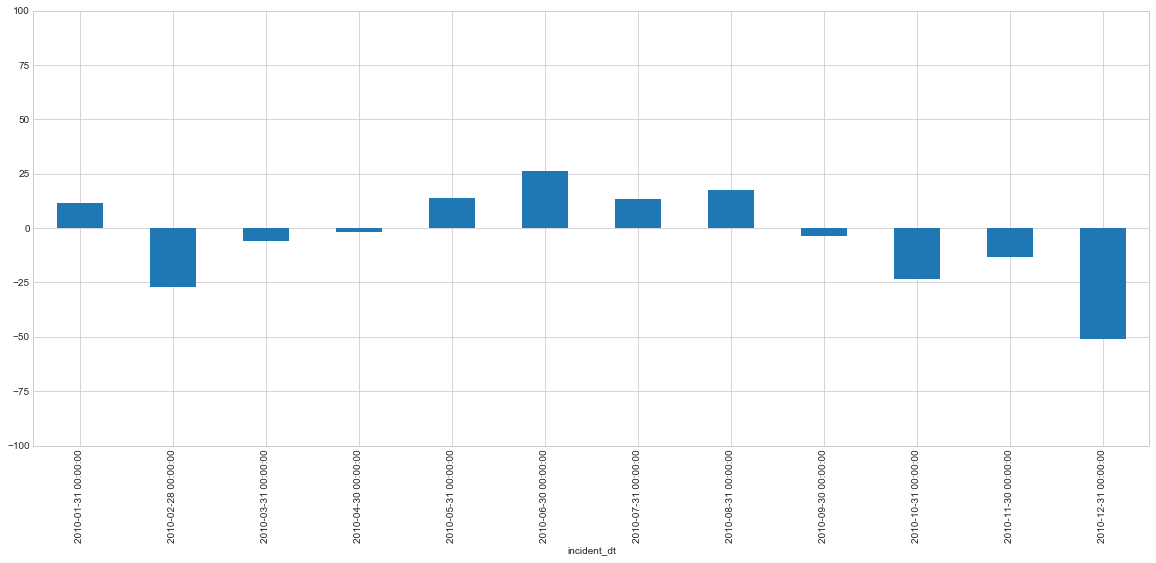

In [102]:
plt.ylim(-100,100)
compare['percent error'].plot(kind='bar')